# Niching
Proceso de optimización de la funcion de Himmelblau usando niching para localizar los cuatro mínimos en una sola ejecución.

## Módulos requeridos para nuestra evolución.
- `deap`
- `numpy`
- `matplotlib`
- `seaborn`
- `math`

## Módulos creados
- `elitism` 

In [1]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
import elitism

# problem constants:
DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = -5.0, 5.0  # boundaries for all dimensions

# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

# sharing constants:
DISTANCE_THRESHOLD = 0.1
SHARING_EXTENT = 5.0

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)


# helper function for creating random float numbers uniformaly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(a, b) for a, b in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attr_float", randomFloat, BOUND_LOW, BOUND_UP)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attr_float)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


## Evaluación de la Función
La implementación de un mecanismo de intercambio generalmente requiere que optimicemos una función que produzca valores de aptitud positivos y busquemos valores máximos en lugar de mínimos. Esto nos permite dividir los valores brutos de aptitud física como una forma de disminuir la aptitud física y compartir prácticamente los recursos entre los individuos vecinos. Como la función de Himmelblau produce valores entre 0 y (aproximadamente) 2000, podemos usar una función modificada que devuelve 2.000 menos el valor original, lo que garantizará que todos los valores de la función sean positivos, mientras transformamos los puntos mínimos en puntos máximos que devuelven el valor de 2000.


In [2]:
# 'Inverted' Himmelblau function as the given individual's fitness:
def himmelblauInverted(individual):
    x = individual[0]
    y = individual[1]
    f = (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
    return 2000.0 - f,  # return a tuple

## Operadores Genéticos

In [3]:
toolbox.register("evaluate", himmelblauInverted)

# wraps the tools.selTournament() with fitness sharing
# same signature as tools.selTournament()
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):

    # get orig fitnesses:
    origFitnesses = [ind.fitness.values[0] for ind in individuals]

    # apply sharing to each individual:
    for i in range(len(individuals)):
        sharingSum = 1

        # iterate over all other individuals
        for j in range(len(individuals)):
            if i != j:
                # calculate eucledean distance between individuals:
                distance = math.sqrt(
                    ((individuals[i][0] - individuals[j][0]) ** 2) + ((individuals[i][1] - individuals[j][1]) ** 2))

                if distance < DISTANCE_THRESHOLD:
                    sharingSum += (1 - distance / (SHARING_EXTENT * DISTANCE_THRESHOLD))

        # reduce fitness accordingly:
        individuals[i].fitness.values = origFitnesses[i] / sharingSum,

    # apply original tools.selTournament() using modified fitness:
    selected = tools.selTournament(individuals, k, tournsize, fit_attr)

    # retrieve original fitness:
    for i, ind in enumerate(individuals):
        ind.fitness.values = origFitnesses[i],

    return selected


# genetic operators:
toolbox.register("select", selTournamentWithSharing, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)


## Evolución de la población

gen	nevals	max    	avg    
0  	300   	1999.92	1861.35
1  	256   	1999.92	1923.09
2  	261   	1999.95	1933.39
3  	260   	1999.95	1937.75
4  	257   	1999.95	1936.95
5  	254   	1999.95	1945.01
6  	253   	1999.97	1949.24
7  	257   	1999.97	1951.29
8  	253   	1999.97	1950.51
9  	255   	1999.97	1952.18
10 	252   	1999.97	1950.47
11 	259   	1999.97	1953.05
12 	254   	1999.97	1949.78
13 	263   	1999.98	1952.01
14 	262   	1999.98	1952.26
15 	254   	1999.98	1959.42
16 	256   	1999.98	1956.38
17 	253   	1999.98	1953.97
18 	260   	1999.98	1950.71
19 	258   	1999.98	1953.67
20 	250   	1999.98	1950.64
21 	261   	1999.98	1953.63
22 	256   	1999.98	1952.55
23 	262   	1999.98	1954.43
24 	252   	1999.98	1958.17
25 	259   	1999.98	1953.15
26 	253   	1999.98	1950.21
27 	257   	1999.98	1942.96
28 	243   	1999.98	1943.85
29 	258   	1999.98	1946.13
30 	255   	1999.98	1946.32
31 	250   	1999.98	1946.58
32 	255   	1999.98	1941.21
33 	256   	1999.98	1946.83
34 	251   	1999.98	1949.55
35 	257   	1999.98	1950.34
3

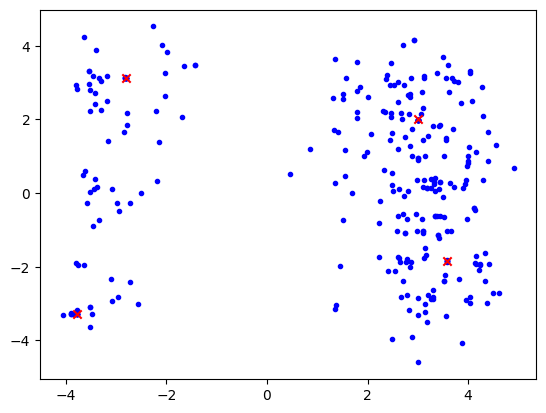

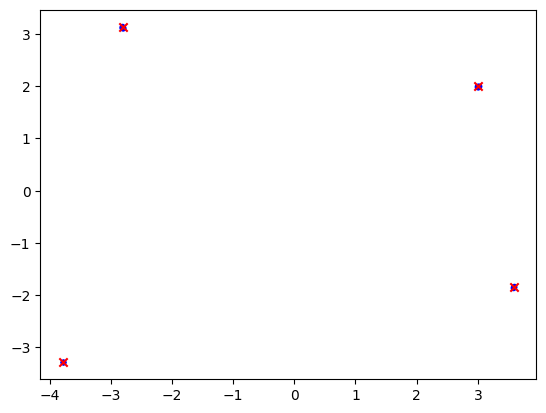

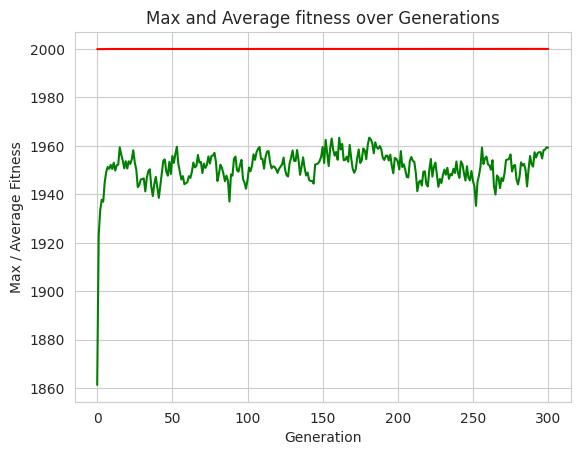

In [4]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # plot solution locations on x-y plane:
    plt.figure(1)
    globalMaxima = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584458, -1.848126]]
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*population), marker='.', color='blue', zorder=0)    # plot solution locations on x-y plane:

    # plot best solutions locations on x-y plane:
    plt.figure(2)
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*hof.items), marker='.', color='blue', zorder=0)

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    plt.figure(3)
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')

    plt.show()


if __name__ == "__main__":
    main()